Processing directory: dir0 2025-03-06 00:58:23.816012
Processing directory: dir1 2025-03-06 00:58:27.028737
Processing directory: dir10 2025-03-06 00:58:30.632861
Processing directory: dir11 2025-03-06 00:58:31.761196
Processing directory: dir12 2025-03-06 00:58:33.179020
Processing directory: dir13 2025-03-06 00:58:35.895477
Processing directory: dir14 2025-03-06 00:58:38.145846
Processing directory: dir15 2025-03-06 00:58:40.345842
Processing directory: dir16 2025-03-06 00:58:41.832969
Processing directory: dir17 2025-03-06 00:58:44.119269
Processing directory: dir18 2025-03-06 00:58:45.666221
Processing directory: dir19 2025-03-06 00:58:49.642174
Processing directory: dir2 2025-03-06 00:58:55.932196
Processing directory: dir20 2025-03-06 00:58:58.418855
Processing directory: dir21 2025-03-06 00:59:05.283531
Processing directory: dir22 2025-03-06 00:59:08.540897
Processing directory: dir23 2025-03-06 00:59:13.079977
Processing directory: dir24 2025-03-06 00:59:16.757213
Processing di

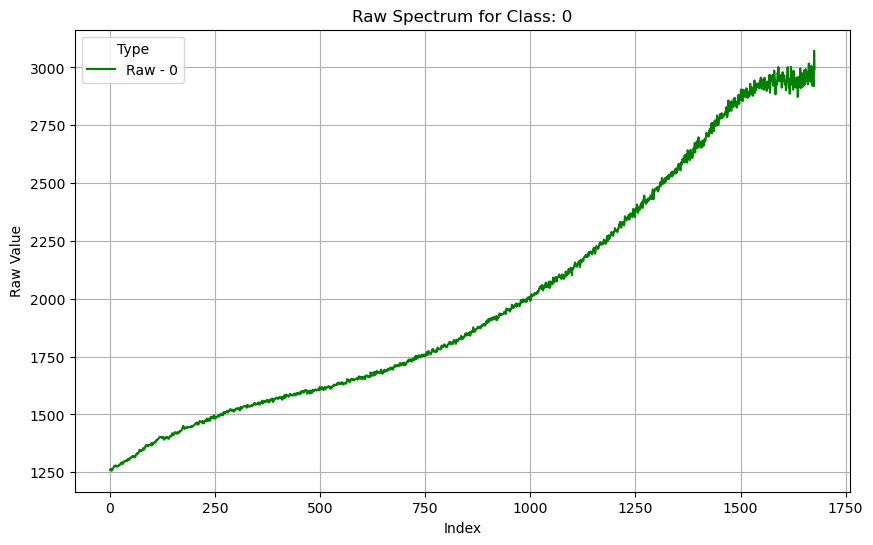

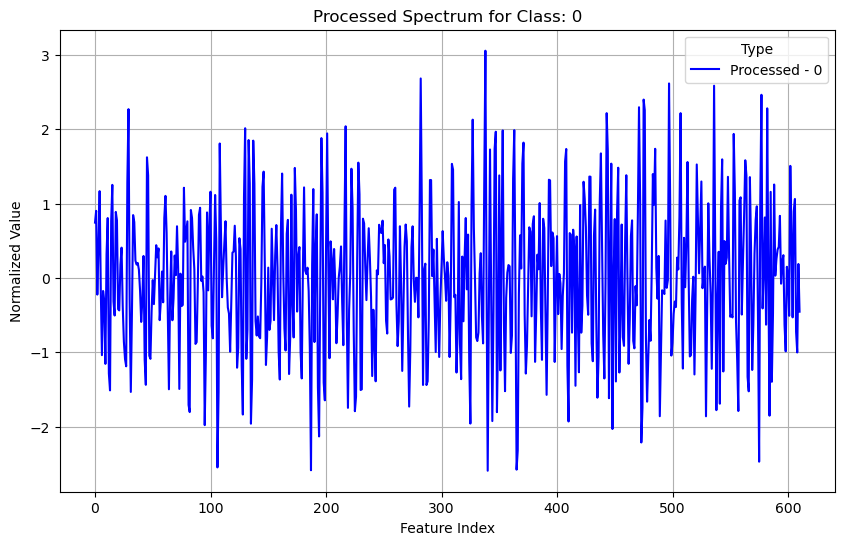

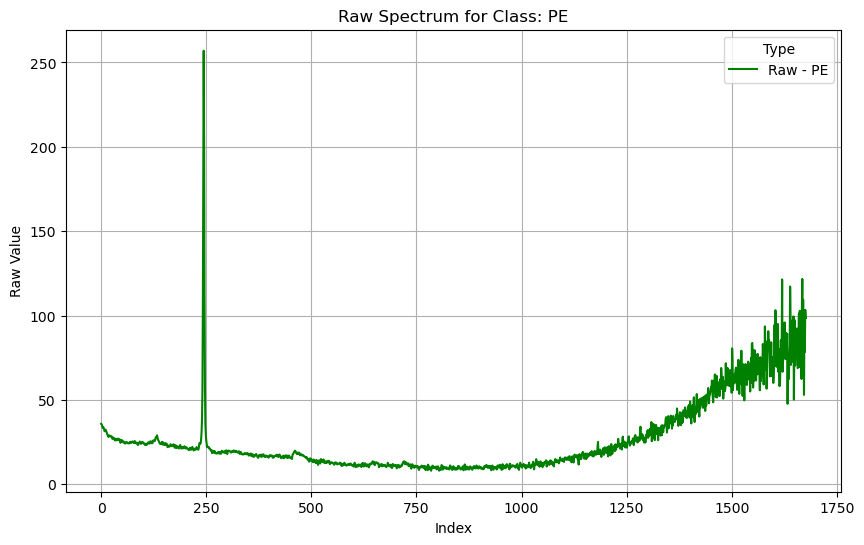

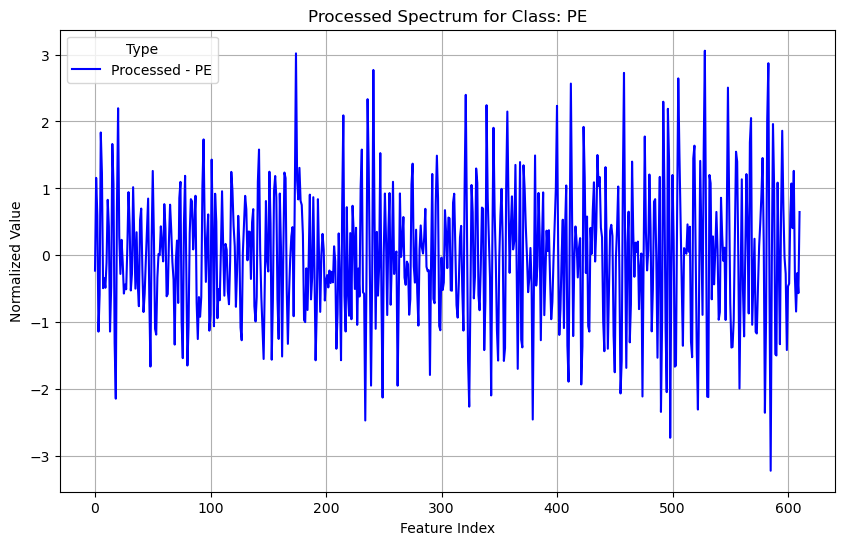

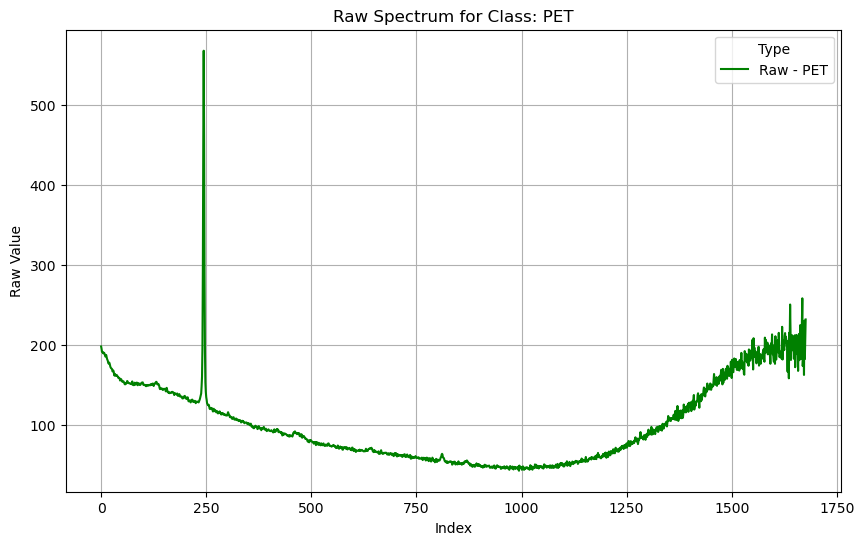

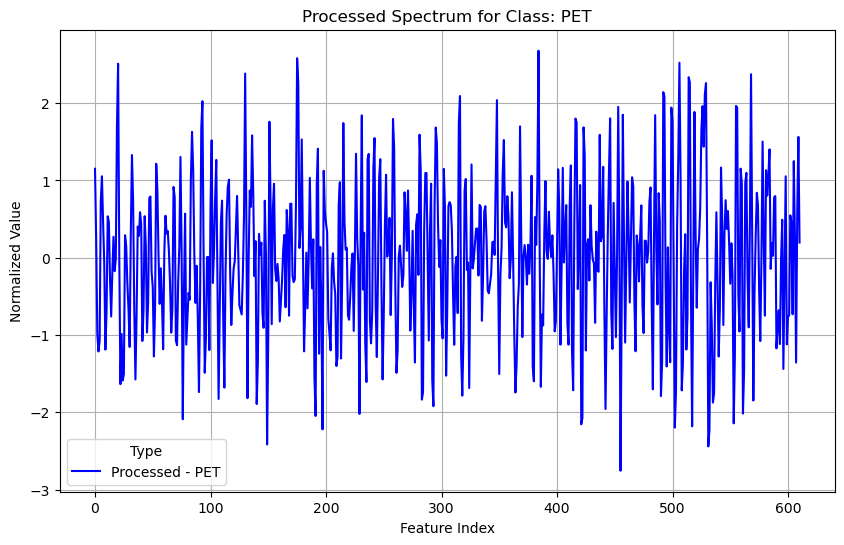

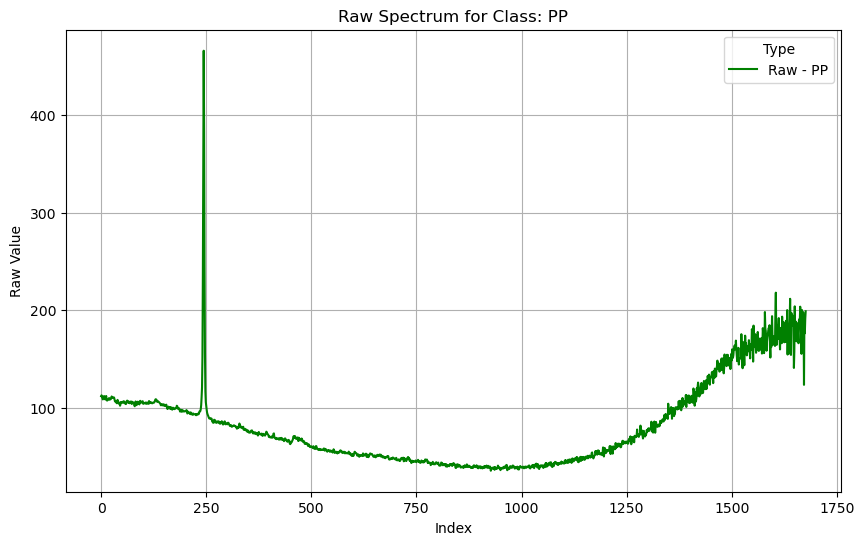

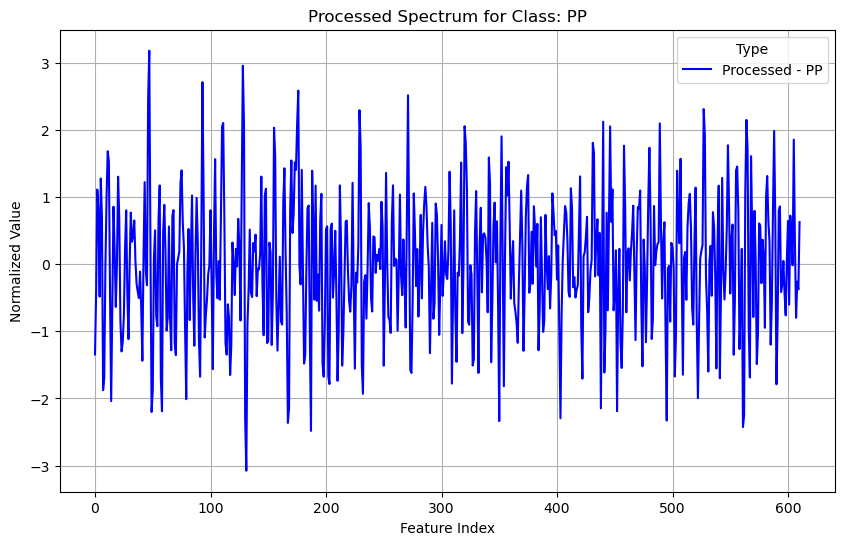

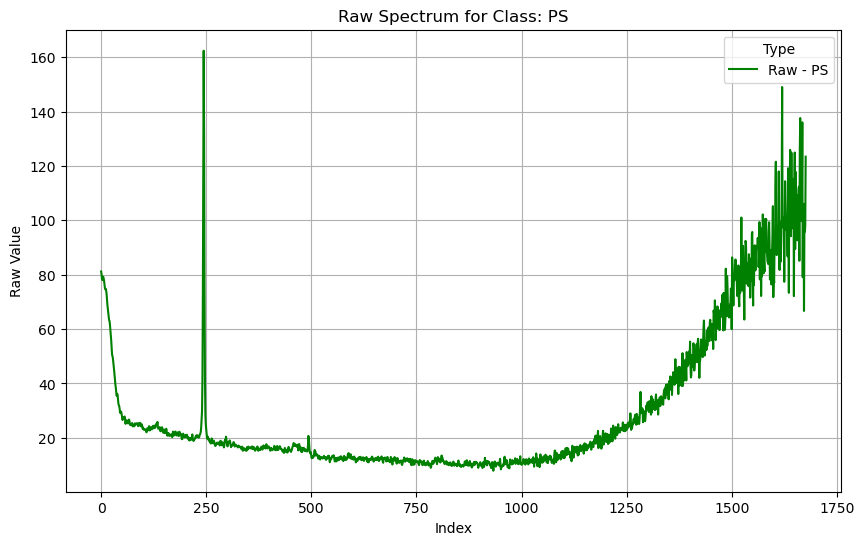

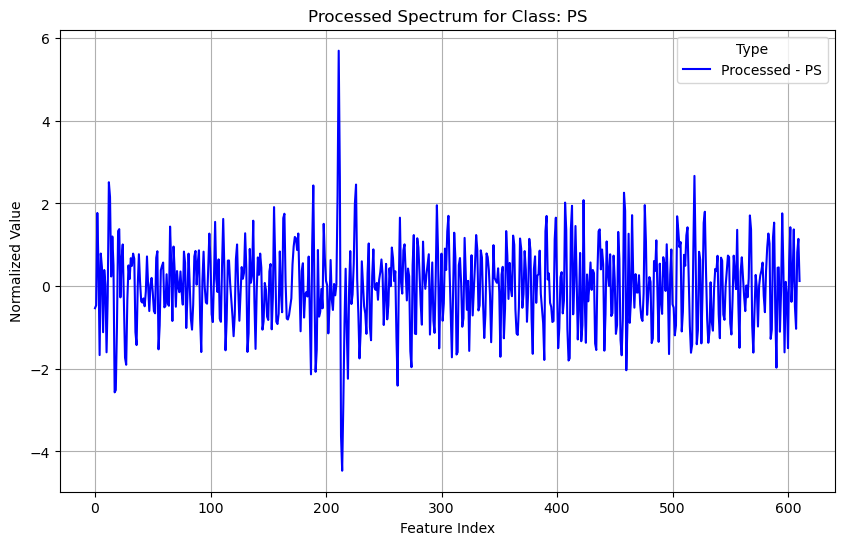

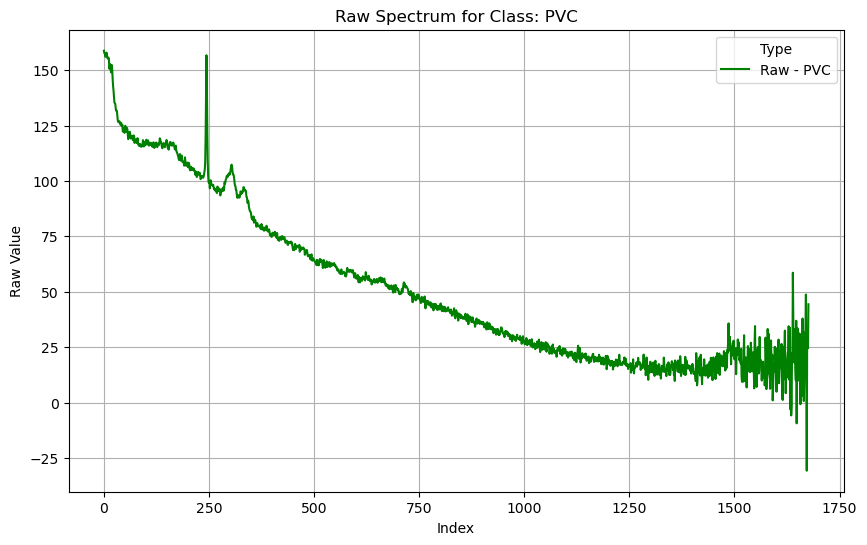

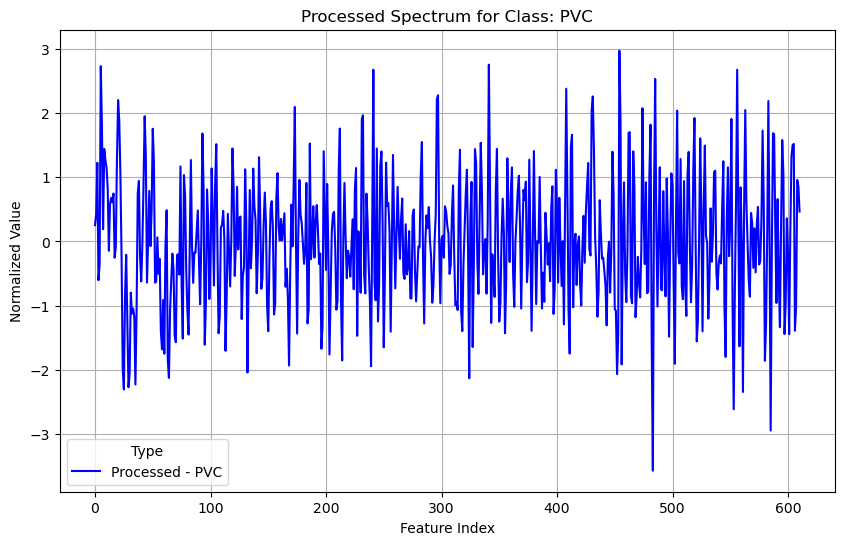

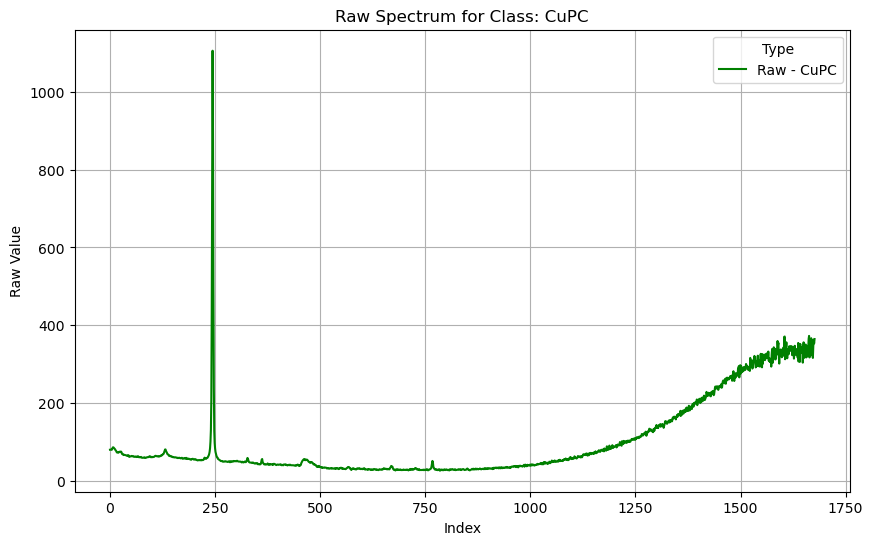

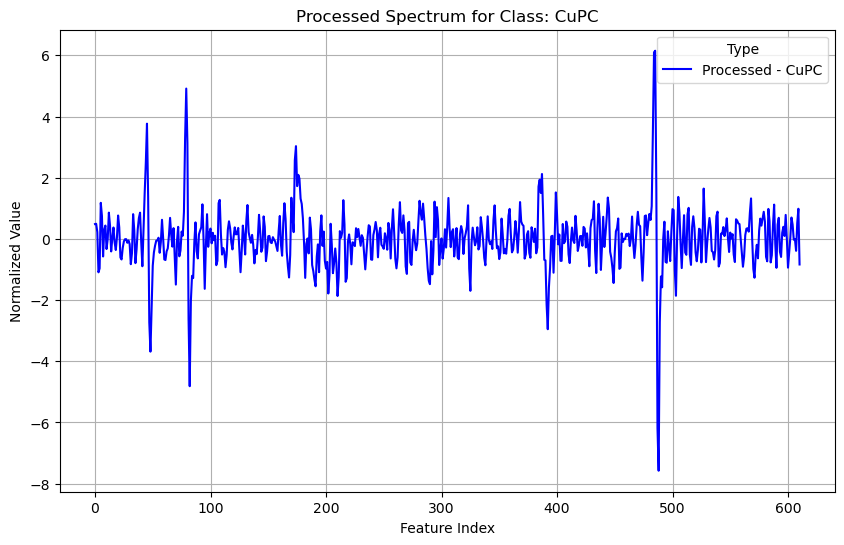

End


In [9]:
import os
import json
import datetime
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define root directory and subdirectories
root = "C:/Users/PayaPc.Com/Downloads/43591_2023_57_MOESM2_ESM/" 
class_names = ['0', 'PE', 'PET', 'PP', 'PS', 'PVC', 'CuPC']
sourceDir = root + "DataAnonym/"
featureDir = root + "FeaturesAnonym/"
dataSplitDir = root + "DataSplit/"  # New directory to store split datasets

# Create lists to store all features and labels
all_features = []
all_labels = []

# Dictionaries to store one sample per class (raw and processed)
raw_samples = {cls: None for cls in range(len(class_names))}  # For raw spectra (ll_t before slicing)
processed_samples = {cls: None for cls in range(len(class_names))}  # For processed spectra (ll after scaling)

# Iterate over directories only
for d in os.listdir(sourceDir):
    dir_path = os.path.join(sourceDir, d)
    if not os.path.isdir(dir_path):  # Skip if not a directory
        print(f"Skipping non-directory item: {d}")
        continue
    
    print(f"Processing directory: {d}", datetime.datetime.now())
    json_file = os.path.join(sourceDir, d, f"{d}.json")
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
            x_temp = np.zeros((len(data), 611))
            
            counter = 0
            for e in data:
                filename = os.path.join(sourceDir, d, 'spectrum', f"{e['id']}.json")
                with open(filename, "r") as sf:
                    ll_t = np.array(json.load(sf))  # Raw spectral data
                    ll = np.gradient(ll_t, axis=0)  # Gradient of raw data
                    ll = ll[int(562/2):int(1785/2)]  # Slice to 611 elements
                    ll_t_sliced = ll_t[int(562/2):int(1785/2)]  # Sliced raw data (for consistency)
                    
                    ll[np.isnan(ll)] = 0
                    ll = ll.reshape(-1, 1)
                    scaler = StandardScaler()
                    ll = scaler.fit_transform(ll).flatten()
                    
                    x_temp[counter, :] = ll
                    all_features.append(ll)
                    # Add label as class index
                    label_idx = class_names.index(next((lbl for lbl in e['label'] if lbl in class_names), '0'))
                    all_labels.append(label_idx)
                    
                    # Store the first raw and processed sample for each class
                    if raw_samples[label_idx] is None:
                        raw_samples[label_idx] = ll_t  # Store full raw spectrum
                        processed_samples[label_idx] = ll  # Store processed spectrum
                    
                counter += 1
    except FileNotFoundError as e:
        print(f"Error: Could not find file {json_file}. Skipping directory {d}.")
        continue
    except Exception as e:
        print(f"Unexpected error in directory {d}: {e}")
        continue

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)

# Split data into 70% training, 20% validation, and 10% test
X_train_temp, X_rest, y_train_temp, y_rest = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_rest, y_rest, test_size=1/3, random_state=42, stratify=y_rest
)

# Create directory to store split datasets
Path(dataSplitDir).mkdir(parents=True, exist_ok=True)

# Save the split datasets
np.savez(dataSplitDir + 'train.npz', x=X_train_temp, y=y_train_temp)
np.savez(dataSplitDir + 'val.npz', x=X_val, y=y_val)
np.savez(dataSplitDir + 'test.npz', x=X_test, y=y_test)

# Print the sizes of the split datasets
print("Training set size:", X_train_temp.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

# Plot raw and processed samples for each class in separate figures
for class_idx in range(len(class_names)):
    raw_sample = raw_samples[class_idx]
    processed_sample = processed_samples[class_idx]
    
    if raw_sample is not None and processed_sample is not None:  # Check if samples exist
        # Plot raw spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(raw_sample, label=f"Raw - {class_names[class_idx]}", color='green', linewidth=1.5)
        plt.title(f'Raw Spectrum for Class: {class_names[class_idx]}')
        plt.xlabel('Index')
        plt.ylabel('Raw Value')
        plt.legend(title="Type")
        plt.grid(True)
        plt.show()
        
        # Plot processed spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(processed_sample, label=f"Processed - {class_names[class_idx]}", color='blue', linewidth=1.5)
        plt.title(f'Processed Spectrum for Class: {class_names[class_idx]}')
        plt.xlabel('Feature Index')
        plt.ylabel('Normalized Value')
        plt.legend(title="Type")
        plt.grid(True)
        plt.show()

print("End")